In [ ]:










import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import nltk
nltk.download("all")
import matplotlib.pyplot as plt
import torch

%matplotlib inline

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloadin

In [ ]:
URL = 'https://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.tar.gz'
# Download Datasets
!wget -P 'Data/' $URL
# Unzip
!tar xvzf 'Data/rt-polaritydata.tar.gz' -C 'Data/'

--2022-01-18 14:02:49--  https://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.tar.gz
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.36
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 487770 (476K) [application/x-gzip]
Saving to: ‘Data/rt-polaritydata.tar.gz’

rt-polaritydata.tar 100%[===================>] 476.34K  --.-KB/s    in 0.08s   

2022-01-18 14:02:49 (5.54 MB/s) - ‘Data/rt-polaritydata.tar.gz’ saved [487770/487770]

rt-polaritydata.README.1.0.txt
rt-polaritydata/rt-polarity.neg
rt-polaritydata/rt-polarity.pos


In [ ]:
def load_text(path):
    """Load text data, lowercase text and save to a list."""

    with open(path, 'rb') as f:
        texts = []
        for line in f:
            texts.append(line.decode(errors='ignore').lower().strip())

    return texts

# Load files
neg_text = load_text('Data/rt-polaritydata/rt-polarity.neg')
pos_text = load_text('Data/rt-polaritydata/rt-polarity.pos')

# Concatenate and label data
texts = np.array(neg_text + pos_text)
labels = np.array([0]*len(neg_text) + [1]*len(pos_text))

In [ ]:
%%time
URL = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip"
FILE = "fastText"

if os.path.isdir(FILE):
    print("fastText exists.")
else:
    !wget -P $FILE $URL
    !unzip $FILE/crawl-300d-2M.vec.zip -d $FILE

--2022-01-18 14:02:56--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1523785255 (1.4G) [application/zip]
Saving to: ‘fastText/crawl-300d-2M.vec.zip’

crawl-300d-2M.vec.z 100%[===================>]   1.42G  46.1MB/s    in 34s     

2022-01-18 14:03:30 (43.4 MB/s) - ‘fastText/crawl-300d-2M.vec.zip’ saved [1523785255/1523785255]

Archive:  fastText/crawl-300d-2M.vec.zip
  inflating: fastText/crawl-300d-2M.vec  
CPU times: user 955 ms, sys: 168 ms, total: 1.12 s
Wall time: 1min 56s


In [ ]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


No GPU available, using the CPU instead.


In [ ]:
from nltk.tokenize import word_tokenize
from collections import defaultdict

def tokenize(texts):
    """Tokenize texts, build vocabulary and find maximum sentence length.
    
    Args:
        texts (List[str]): List of text data
    
    Returns:
        tokenized_texts (List[List[str]]): List of list of tokens
        word2idx (Dict): Vocabulary built from the corpus
        max_len (int): Maximum sentence length
    """

    max_len = 0
    tokenized_texts = []
    word2idx = {}

    # Add <pad> and <unk> tokens to the vocabulary
    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1

    # Building our vocab from the corpus starting from index 2
    idx = 2
    for sent in texts:
        tokenized_sent = word_tokenize(sent)

        # Add `tokenized_sent` to `tokenized_texts`
        tokenized_texts.append(tokenized_sent)

        # Add new token to `word2idx`
        for token in tokenized_sent:
            if token not in word2idx:
                word2idx[token] = idx
                idx += 1

        # Update `max_len`
        max_len = max(max_len, len(tokenized_sent))

    return tokenized_texts, word2idx, max_len

def encode(tokenized_texts, word2idx, max_len):
    """Pad each sentence to the maximum sentence length and encode tokens to
    their index in the vocabulary.

    Returns:
        input_ids (np.array): Array of token indexes in the vocabulary with
            shape (N, max_len). It will the input of our CNN model.
    """

    input_ids = []
    for tokenized_sent in tokenized_texts:
        # Pad sentences to max_len
        tokenized_sent += ['<pad>'] * (max_len - len(tokenized_sent))

        # Encode tokens to input_ids
        input_id = [word2idx.get(token) for token in tokenized_sent]
        input_ids.append(input_id)
    
    return np.array(input_ids)

In [ ]:
from tqdm import tqdm_notebook

def load_pretrained_vectors(word2idx, fname):
    """Load pretrained vectors and create embedding layers.
    
    Args:
        word2idx (Dict): Vocabulary built from the corpus
        fname (str): Path to pretrained vector file

    Returns:
        embeddings (np.array): Embedding matrix with shape (N, d) where N is
            the size of word2idx and d is embedding dimension
    """

    print("Loading pretrained vectors...")
    fin = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())

    # Initilize random embeddings
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    embeddings[word2idx['<pad>']] = np.zeros((d,))

    # Load pretrained vectors
    count = 0
    for line in tqdm_notebook(fin):
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        if word in word2idx:
            count += 1
            embeddings[word2idx[word]] = np.array(tokens[1:], dtype=np.float32)

    print(f"There are {count} / {len(word2idx)} pretrained vectors found.")

    return embeddings

In [ ]:
# Tokenize, build vocabulary, encode tokens
print("Tokenizing...\n")
tokenized_texts, word2idx, max_len = tokenize(texts)
input_ids = encode(tokenized_texts, word2idx, max_len)

# Load pretrained vectors
embeddings = load_pretrained_vectors(word2idx, "fastText/crawl-300d-2M.vec")
embeddings = torch.tensor(embeddings)

Tokenizing...

Loading pretrained vectors...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

There are 18526 / 20286 pretrained vectors found.


In [ ]:
from torch.utils.data import (TensorDataset, DataLoader, RandomSampler,
                              SequentialSampler)

def data_loader(train_inputs, val_inputs, train_labels, val_labels,
                batch_size=50):
    """Convert train and validation sets to torch.Tensors and load them to
    DataLoader.
    """

    # Convert data type to torch.Tensor
    train_inputs, val_inputs, train_labels, val_labels =\
    tuple(torch.tensor(data) for data in
          [train_inputs, val_inputs, train_labels, val_labels])

    # Specify batch_size
    batch_size = 50

    # Create DataLoader for training data
    train_data = TensorDataset(train_inputs, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Create DataLoader for validation data
    val_data = TensorDataset(val_inputs, val_labels)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

    return train_dataloader, val_dataloader

In [ ]:
from sklearn.model_selection import train_test_split

# Train Test Split
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    input_ids, labels, test_size=0.1, random_state=42)

# Load data to PyTorch DataLoader
train_dataloader, val_dataloader = \
data_loader(train_inputs, val_inputs, train_labels, val_labels, batch_size=50)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_NLP(nn.Module):
    """An 1D Convulational Neural Network for Sentence Classification."""
    def __init__(self,
                 pretrained_embedding=None,
                 freeze_embedding=False,
                 vocab_size=None,
                 embed_dim=300,
                 filter_sizes=[3, 4, 5],
                 num_filters=[100, 100, 100],
                 num_classes=2,
                 dropout=0.5):
        """
        The constructor for CNN_NLP class.

        Args:
            pretrained_embedding (torch.Tensor): Pretrained embeddings with
                shape (vocab_size, embed_dim)
            freeze_embedding (bool): Set to False to fine-tune pretraiend
                vectors. Default: False
            vocab_size (int): Need to be specified when not pretrained word
                embeddings are not used.
            embed_dim (int): Dimension of word vectors. Need to be specified
                when pretrained word embeddings are not used. Default: 300
            filter_sizes (List[int]): List of filter sizes. Default: [3, 4, 5]
            num_filters (List[int]): List of number of filters, has the same
                length as `filter_sizes`. Default: [100, 100, 100]
            n_classes (int): Number of classes. Default: 2
            dropout (float): Dropout rate. Default: 0.5
        """

        super(CNN_NLP, self).__init__()
        # Embedding layer
        if pretrained_embedding is not None:
            self.vocab_size, self.embed_dim = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
        else:
            self.embed_dim = embed_dim
            self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                          embedding_dim=self.embed_dim,
                                          padding_idx=0,
                                          max_norm=5.0)
        # Conv Network
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=self.embed_dim,
                      out_channels=num_filters[i],
                      kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))
        ])
        # Fully-connected layer and Dropout
        self.fc = nn.Linear(np.sum(num_filters), num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input_ids):
        """Perform a forward pass through the network.

        Args:
            input_ids (torch.Tensor): A tensor of token ids with shape
                (batch_size, max_sent_length)

        Returns:
            logits (torch.Tensor): Output logits with shape (batch_size,
                n_classes)
        """

        # Get embeddings from `input_ids`. Output shape: (b, max_len, embed_dim)
        x_embed = self.embedding(input_ids).float()

        # Permute `x_embed` to match input shape requirement of `nn.Conv1d`.
        # Output shape: (b, embed_dim, max_len)
        x_reshaped = x_embed.permute(0, 2, 1)

        # Apply CNN and ReLU. Output shape: (b, num_filters[i], L_out)
        x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]

        # Max pooling. Output shape: (b, num_filters[i], 1)
        x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2])
            for x_conv in x_conv_list]
        
        # Concatenate x_pool_list to feed the fully connected layer.
        # Output shape: (b, sum(num_filters))
        x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list],
                         dim=1)
        
        # Compute logits. Output shape: (b, n_classes)
        logits = self.fc(self.dropout(x_fc))

        return logits

In [ ]:
import torch.optim as optim

def initilize_model(pretrained_embedding=None,
                    freeze_embedding=False,
                    vocab_size=None,
                    embed_dim=300,
                    filter_sizes=[3, 4, 5],
                    num_filters=[100, 100, 100],
                    num_classes=2,
                    dropout=0.5,
                    learning_rate=0.01):
    """Instantiate a CNN model and an optimizer."""

    assert (len(filter_sizes) == len(num_filters)), "filter_sizes and \
    num_filters need to be of the same length."

    # Instantiate CNN model
    cnn_model = CNN_NLP(pretrained_embedding=pretrained_embedding,
                        freeze_embedding=freeze_embedding,
                        vocab_size=vocab_size,
                        embed_dim=embed_dim,
                        filter_sizes=filter_sizes,
                        num_filters=num_filters,
                        num_classes=2,
                        dropout=0.5)
    
    # Send model to `device` (GPU/CPU)
    cnn_model.to(device)

    # Instantiate Adadelta optimizer
    optimizer = optim.Adadelta(cnn_model.parameters(),
                               lr=learning_rate,
                               rho=0.95)

    return cnn_model, optimizer

In [ ]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility."""

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, optimizer, train_dataloader, val_dataloader=None, epochs=10):
    """Train the CNN model."""
    
    # Tracking best validation accuracy
    best_accuracy = 0

    # Start training loop
    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {\
    'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*60)

    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================

        # Tracking time and loss
        t0_epoch = time.time()
        total_loss = 0

        # Put the model into the training mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            # Load batch to GPU
            b_input_ids, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Update parameters
            optimizer.step()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        # =======================================
        #               Evaluation
        # =======================================
        if val_dataloader is not None:
            # After the completion of each training epoch, measure the model's
            # performance on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Track the best accuracy
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {avg_train_loss:^12.6f} | {\
            val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            
    print("\n")
    print(f"Training complete! Best accuracy: {best_accuracy:.2f}%.")

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's
    performance on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled
    # during the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [ ]:
# CNN-rand: Word vectors are randomly initialized.
set_seed(42)
cnn_rand, optimizer = initilize_model(vocab_size=len(word2idx),
                                      embed_dim=300,
                                      learning_rate=0.25,
                                      dropout=0.5)
train(cnn_rand, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.685883   |  0.650875  |   61.67   |   43.00  
   2    |   0.628970   |  0.617810  |   65.40   |   42.89  
   3    |   0.570185   |  0.582977  |   67.76   |   44.78  
   4    |   0.509048   |  0.560992  |   70.02   |   43.75  
   5    |   0.431322   |  0.543243  |   72.47   |   44.57  
   6    |   0.364034   |  0.531047  |   72.92   |   42.36  
   7    |   0.292034   |  0.535552  |   72.47   |   42.35  
   8    |   0.236022   |  0.540053  |   72.65   |   42.30  
   9    |   0.189231   |  0.539132  |   71.93   |   42.54  
  10    |   0.145939   |  0.570638  |   71.20   |   43.54  
  11    |   0.125004   |  0.564436  |   74.20   |   43.36  
  12    |   0.099392   |  0.560815  |   73.28   |   43.23  
  13    |   0.088222   |  0.597943  |   72.65   |   43.04  
  14    |   0.073493   |  0.612296  |   73.83   |   47.57  
  15    |   0.065616

In [ ]:
set_seed(42)
cnn_static, optimizer = initilize_model(pretrained_embedding=embeddings,
                                        freeze_embedding=True,
                                        learning_rate=0.25,
                                        dropout=0.5)
train(cnn_static, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.584872   |  0.470015  |   77.20   |   22.86  
   2    |   0.451392   |  0.433366  |   80.56   |   22.81  
   3    |   0.395049   |  0.412271  |   81.29   |   22.68  
   4    |   0.337329   |  0.405322  |   81.83   |   22.70  
   5    |   0.288469   |  0.400671  |   82.20   |   22.70  
   6    |   0.231534   |  0.402071  |   82.65   |   22.57  
   7    |   0.193418   |  0.411430  |   81.56   |   22.41  
   8    |   0.154324   |  0.413964  |   82.20   |   22.49  
   9    |   0.118777   |  0.434903  |   82.28   |   22.50  
  10    |   0.089448   |  0.443204  |   82.65   |   22.65  
  11    |   0.077348   |  0.462383  |   82.39   |   22.70  
  12    |   0.061865   |  0.471348  |   82.29   |   22.61  
  13    |   0.049411   |  0.483797  |   83.37   |   22.58  
  14    |   0.046567   |  0.515852  |   82.02   |   35.64  
  15    |   0.035463

In [ ]:
set_seed(42)
cnn_non_static, optimizer = initilize_model(pretrained_embedding=embeddings,
                                            freeze_embedding=False,
                                            learning_rate=0.25,
                                            dropout=0.5)
train(cnn_non_static, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.584045   |  0.468041  |   77.39   |   58.39  
   2    |   0.447597   |  0.428951  |   80.93   |   59.36  
   3    |   0.385138   |  0.404394  |   81.56   |   58.14  
   4    |   0.323716   |  0.400096  |   82.29   |   57.90  
   5    |   0.272988   |  0.395365  |   82.28   |   57.86  
   6    |   0.214323   |  0.403277  |   82.56   |   57.75  
   7    |   0.174551   |  0.419667  |   81.48   |   57.58  
   8    |   0.131929   |  0.422208  |   82.29   |   57.99  
   9    |   0.098636   |  0.430448  |   82.11   |   57.89  
  10    |   0.072827   |  0.447724  |   82.38   |   58.76  
  11    |   0.059485   |  0.464598  |   83.20   |   58.79  
  12    |   0.046264   |  0.494073  |   81.65   |   60.25  
  13    |   0.037146   |  0.507813  |   83.10   |   58.99  
  14    |   0.032602   |  0.519452  |   82.29   |   58.88  
  15    |   0.025012

In [ ]:
def predict(text, model=cnn_non_static.to("cpu"), max_len=62):
    """Predict probability that a review is positive."""

    # Tokenize, pad and encode text
    tokens = word_tokenize(text.lower())
    padded_tokens = tokens + ['<pad>'] * (max_len - len(tokens))
    input_id = [word2idx.get(token, word2idx['<unk>']) for token in padded_tokens]

    # Convert to PyTorch tensors
    input_id = torch.tensor(input_id).unsqueeze(dim=0)

    # Compute logits
    logits = model.forward(input_id)

    #  Compute probability
    probs = F.softmax(logits, dim=1).squeeze(dim=0)

    print(f"This review is {probs[1] * 100:.2f}% positive.")


In [ ]:
predict("All of friends slept while watching this movie. But I really enjoyed it.")
predict("I have waited so long for this movie. I am now so satisfied and happy.")
predict("This movie is long and boring.")
predict("I don't like the ending.")

This review is 34.72% positive.
This review is 92.37% positive.
This review is 0.01% positive.
This review is 6.63% positive.


In [ ]:
import matplotlib.pyplot as plt



In [ ]:
!pip install skorch
from skorch import NeuralNetClassifier
from skorch.helper import predefined_split
from skorch.callbacks import EarlyStopping, Checkpoint, LoadInitState
from skorch.dataset import CVSplit, Dataset

# Specify validation set
val_dataset = Dataset(val_inputs, val_labels)

# Specify callbacks and checkpoints
cp = Checkpoint(monitor='valid_acc_best', dirname='exp1')
callbacks = [
    ('early_stop', EarlyStopping(monitor='valid_acc', patience=5, lower_is_better=False)),
    cp
]

net = NeuralNetClassifier(
    # Module
    module=CNN_NLP,
    module__pretrained_embedding=embeddings,
    module__freeze_embedding=False,
    module__dropout=0.5,
    # Optimizer
    criterion=nn.CrossEntropyLoss,
    optimizer=optim.Adadelta,
    optimizer__lr=0.25,
    optimizer__rho=0.95,
    # Others
    max_epochs=20,
    batch_size=50,
    train_split=predefined_split(val_dataset),
    iterator_train__shuffle=True,
    warm_start=False,
    callbacks=callbacks,
    device=device
)

In [ ]:
set_seed(42)
_ = net.fit(np.array(train_inputs), train_labels)

valid_acc_best = np.max(net.history[:, 'valid_acc'])
print(f"Training complete! Best accuracy: {valid_acc_best * 100:.2f}%")

  epoch    train_loss    valid_acc    valid_loss    cp      dur
-------  ------------  -----------  ------------  ----  -------
      1        0.5309       0.8022        0.4320     +  57.7598
      2        0.3496       0.8154        0.4023     +  57.5342
      3        0.2700       0.8257        0.3957     +  57.4825
      4        0.2043       0.8257        0.4129        57.3886
      5        0.1563       0.8257        0.4257        57.0315
      6        0.1078       0.8313        0.4560     +  57.4893
      7        0.0854       0.8154        0.4760        57.3495
      8        0.0589       0.8182        0.5029        57.3612
      9        0.0442       0.8172        0.5407        57.8406
     10        0.0320       0.8238        0.5561        57.8681
     11        0.0267       0.8322        0.5847     +  57.9661
     12        0.0214       0.8163        0.6145        57.6925
     13        0.0187       0.8247        0.6256        57.1609
     14        0.0161       0.8304      

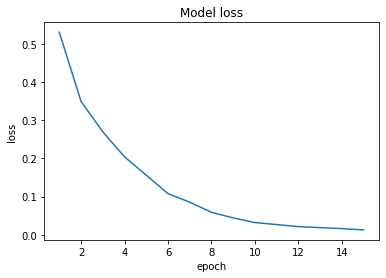

In [ ]:
train_loss = [0.5309,.3496,.2700,.2043,.1563,.1078,.0854,.0589,.0442,.0320,.0267,.0214,.0187,.0161,.0127]
valid_loss = [0.4320,0.4023,.3957,.4129,.4257,.4560,.4760,.5029,.5407,.5561,.5847,.6145,.6256,.6475,.6525]
epoch = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
plt.plot(epoch, train_loss)
 
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Model loss')
plt.show()


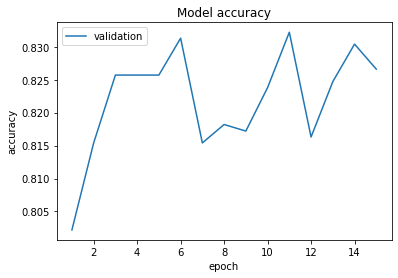

In [ ]:
train_loss = [0.5309,.3496,.2700,.2043,.1563,.1078,.0854,.0589,.0442,.0320,.0267,.0214,.0187,.0161,.0127]
valid_acc = [0.8022,0.8154,.8257,.8257,.8257,.8313,.8154,.8182,.8172,.8238,.8322,.8163,.8247,.8304,.8266]
epoch = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
plt.plot(epoch, valid_acc,label= "validation")

 

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Model accuracy')
plt.legend()
plt.show()
